## Import

In [1]:
from yasai_funcs import yasai
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# ### for_multi_GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# print(torch.cuda.device_count())
# print(torch.cuda.is_available())

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_11'

In [4]:
dataset_folder = 'finetuneset_v1.0.0'

train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_train_set')
valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_valid_set')
test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_test_set')

## Aug

In [5]:
img_size = 224
train_bsz = 64
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8
CLASSES = ['N', 'L', 'R']

## Dataset

In [6]:
def get_df(img_path):
    images, labels = [], []

    i = 0

    for get_img_name in os.listdir(img_path):
        images += [os.path.join(img_path, get_img_name)] # NORMAL_G1_Lid1_LRid293_Gid3133_Bl30.png
        if get_img_name.split('_')[1] == 'L':
            labels += [CLASSES[0]]
        elif get_img_name.split('_')[1] == 'R':
            labels += [CLASSES[1]]
        else:
            labels += [CLASSES[2]]
        
        i = i+1

    PathDF = pd.DataFrame({'images': images, 'labels': labels})
    print(i)
    PathDF.head()
    return PathDF

In [7]:
train_df = get_df(train_img_path)
valid_df = get_df(valid_img_path)
test_df = get_df(test_img_path)

3788
1037
917


In [8]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [9]:
train_df.groupby('labels').agg('size')

labels
L    1476
N    1494
R     818
dtype: int64

In [10]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

In [11]:
# mask_path = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/dataset_C_v_2.9.3/train_for_base_mask/RSLN_L_G10_Lid45_LRid112_Gid7024_C4.png'
# label = Image.open(mask_path)
# label = np.array(label)

In [12]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['images']).convert('RGB'))
            images = self.transform(images)

            if self.path_df.iloc[idx]['labels'] == CLASSES[0]:
                lables = torch.tensor([1, 0, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[1]:
                lables = torch.tensor([0, 1, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[2]:
                lables = torch.tensor([0, 0, 1], dtype=torch.float32)

        return images, lables

In [13]:
train_data = mod_Dataset(train_df, transform)
valid_data = mod_Dataset(valid_df, transform)
test_data  = mod_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=train_bsz, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=valid_bsz, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=test_bsz , shuffle=False, num_workers=0)

## Model

In [14]:
class resnet34(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = torchvision.models.resnet34(weights=None)
        self.fc1 = nn.Linear(1000, num_classes)

    def forward(self, input):
        output = self.base_model(input)
        output = self.fc1(output)
        output = torch.softmax(output, dim=1)
        return output

In [15]:
model = resnet34(3).to(device)
# print(model)
t = torch.randn((4, 3, 224, 224)).to(device)
print(t.shape)
get = model(t)
print(get.shape)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4, 3])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3])


## Train

In [16]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            _, y = y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return (num_correct/num_samples).item()

def train(epochs, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # forward
            scores = model(data)
            # print(scores)
            loss = criterion(scores, targets)
            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.8f}\tAccuracy:{acc:.8f}")

    return model

In [17]:
trained_resnet34_model = train(10, model)

Epoch 0: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Loss:1.04231245	Accuracy:0.22137403


Epoch 1: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Loss:0.94815409	Accuracy:0.43620500


Epoch 2: 100%|██████████| 59/59 [00:14<00:00,  4.04it/s]


Loss:0.74354773	Accuracy:0.43511447


Epoch 3: 100%|██████████| 59/59 [00:15<00:00,  3.88it/s]


Loss:0.63818261	Accuracy:0.50817883


Epoch 4: 100%|██████████| 59/59 [00:14<00:00,  3.93it/s]


Loss:0.60387466	Accuracy:0.55943292


Epoch 5: 100%|██████████| 59/59 [00:15<00:00,  3.93it/s]


Loss:0.58063231	Accuracy:0.31952018


Epoch 6: 100%|██████████| 59/59 [00:14<00:00,  3.97it/s]


Loss:0.56900139	Accuracy:0.50599778


Epoch 7: 100%|██████████| 59/59 [00:15<00:00,  3.91it/s]


Loss:0.56252463	Accuracy:0.47437292


Epoch 8: 100%|██████████| 59/59 [00:15<00:00,  3.79it/s]


Loss:0.56233158	Accuracy:0.54089421


Epoch 9: 100%|██████████| 59/59 [00:15<00:00,  3.86it/s]


Loss:0.55694465	Accuracy:0.57033801


In [18]:
yasai.model_save_v1(trained_resnet34_model, 'resnet34_trainsteprgb_2305290849_')

Successfully saved to /home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305291154.pt


In [19]:
# trained_resnet34_model = yasai.model_load_v1('/home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305291051.pt')

accuracy = 0.40971488912354803
avg_precision = 0.3743888961794291
avg_recall = 0.34646444857999675


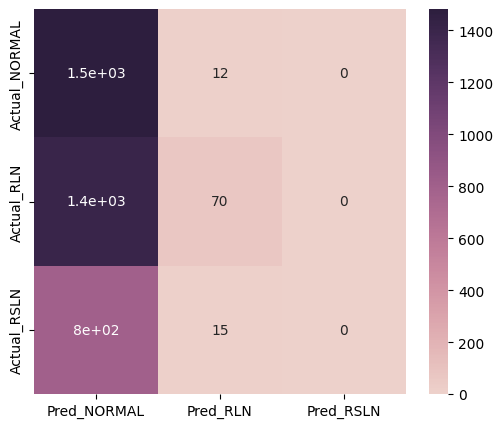

In [20]:
_ = yasai.confusion_matrix(train_data, trained_resnet34_model, ['NORMAL', 'RLN', 'RSLN'])

In [97]:
t = torch.randn((1, 3, 224, 224)).to(device)
print(t.shape)
get = trained_resnet34_model(t)
print(get)

torch.Size([1, 3, 224, 224])
tensor([[0.4990, 0.4346, 0.0664]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
